In [276]:
import os
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pymorphy2
import seaborn as sns
sns.set_style("whitegrid")
from nltk.tokenize import WhitespaceTokenizer
from nltk.corpus import stopwords
from string import punctuation
from operator import itemgetter

# HW1:  Сравнение стилей текстов
### Выполнили:  Булгаков Дмитрий, Тефикова Алие
### Группа ИАД-2

# 1. Загрузка данных

Составьте самостоятельно как минимум две коллекции
текстов разных стилей (например, коллекция текстов в публицистическом
стиле и коллекция текстов в научном стиле). Коллекции текстов
должны быть достаточно большие (порядка 5000 токенов). Посчитайте
количество токенов и типов в каждой коллекции.

### 1.1 Получение  данных из файла

In [277]:
def remove_control_characters(text_string):
    return ''.join(filter(None, text_string.splitlines()))

### 1.1.1 Загрузка художественных текстов (Портрет Дориана Грея,  Оскар Уайльд)

«Портре́т Дориана Гре́я» (англ. The Picture of Dorian Gray) — единственный опубликованный роман Оскара Уайльда. В жанровом отношении представляет смесь романа воспитания с моральной притчей. Существует в двух версиях — в 13 главах (1890 года) и в 20 главах (1891 года). Стал самым успешным произведением Уайльда, более 30 раз экранизировался.

<b>Link:<b> http://lib.ru/WILDE/doriangray.txt

In [278]:
fiction = open('data/dorian_gray.txt', encoding='utf-8').read()
fiction = remove_control_characters(fiction)

In [279]:
fiction = fiction[:105000] #приводим тексты к такому размеру, чтобы количество токенов было примерно одинаковым 

### 1.1.2 Загрузка  публицистических текстов (статьи lenta.ru) 

Lenta.ru — одно из ведущих российских новостных интернет-изданий, основанное в 1999 году Антоном Носиком при содействии Фонда эффективной политики. Работает круглосуточно, освещая мировые и внутрироссийские новости.

Для коллекции было взято большое количество новостей, опубликованных за февраль нынешнего года.

<b>Link<b>: http://lenta.ru

In [280]:
journalistic = open('data/lentaru.txt', encoding='utf-8').read()
journalistic = remove_control_characters(journalistic)

### 1.1.3 Загрузка  научных текстов (Молодежная Наука 2016)

Материалы Всероссийской научно-практической конференции молодых ученых, аспирантов и студентов, посвященной 150-летию со дня рождения профессора В.Н. Варгина (Пермь, 14-18 марта 2016 года)

<b>Link<b>: http://pgsha.ru/web/science/scientificarticles/

In [281]:
scientific = open('data/perm_conf.txt', encoding='utf-8').read()
scientific = remove_control_characters(scientific)

In [282]:
scientific = scientific[:140000] #приводим тексты к такому размеру, чтобы количество токенов было примерно одинаковым 

### 1.1.4 Загрузка  текстов  разговорного стиля (корпус составленный на базе Twitter )

В качестве источника текстов была выбрана платформа микроблогинга Twitter. Современные поисковые системы и имеющиеся в открытом доступе инструменты по сбору текстовых отзывов не позволяют собирать актуальные отзывы и оперативно работать с данными. В связи с этим на основе программного интерефейса API twitter  был разработан программный инструмент для извлечения отзывов об интересующих товарах, услугах,  событиях,  персонах из микроблоггинг-платформы twitter,  который позволяет учитывать время публикации сообщения и авторитетность автора сообщения. Этот инструмент использовался для сбора неразмеченного корпуса. В корпусе содержится более 15 миллионов записей за время с конца ноября 2013 года до конца февраля 2014 года.

<b>Link:<b> http://study.mokoron.com

In [283]:
conversational = open('data/twitter.txt', encoding='utf-8').read()
conversational = remove_control_characters(conversational)

In [284]:
conversational = conversational[:100000] #приводим тексты к такому размеру, чтобы количество токенов было примерно одинаковым 

### 1.2 Подсчет токенов и типов

In [285]:
exclude_symbols = set(punctuation + '0123456789' + u'–—' + u'«»' + u'“')

In [286]:
def tokenize(text, exlude_symb):
    text = text.lower()
    text_merged = ''.join(ch for ch in text if ch not in exlude_symb)
    text_tokens = WhitespaceTokenizer().tokenize(text_merged.lower())
    return text_tokens

In [287]:
def print_results(tokens):
    print('N of tokens: ', len(tokens))
    types = nltk.FreqDist(tokens)
    print('N of types:', len(types))

### 1.2.1 Токены и типы для  художественного стиля

In [288]:
fiction_tokens = tokenize(fiction, exclude_symbols)
print_results(fiction_tokens)

N of tokens:  14227
N of types: 5664


### 1.2.2 Токены и типы для публицистического стиля

In [289]:
journalistic_tokens = tokenize(journalistic, exclude_symbols)
print_results(journalistic_tokens)

N of tokens:  13699
N of types: 6015


### 1.2.3 Токены и типы для  научного стиля

In [290]:
scientific_tokens = tokenize(scientific, exclude_symbols)
print_results(scientific_tokens)

N of tokens:  14732
N of types: 5370


### 1.2.4 Токены и типы для  разговорного стиля

In [291]:
conversational_tokens = tokenize(conversational, exclude_symbols)
print_results(conversational_tokens)

N of tokens:  14171
N of types: 6155


### 2. Подсчет частей речи

### 2.1 Подсчет частоты вхождений слов

In [292]:
stop_words = stopwords.words('russian') + [u'это', u'№', u'гсха', u'это', u'оо', u'изз', u'б']
morph_analyzer = pymorphy2.MorphAnalyzer()

In [293]:
def word_freq_count(tokens, morph, stopwords=None):
    lemmata = nltk.FreqDist()
    types = nltk.FreqDist(tokens)
    
    for t in types:
        l = morph.parse(t)[0].normal_form
        if l in lemmata:
            lemmata[l] += types[t]
        else:
            lemmata[l] = types[t]
                
    if (stopwords != None):
        lemmata = lemmata_remove_stopwords(lemmata, stopwords)
    
    return lemmata

In [294]:
def lemmata_remove_stopwords(lem, stopwords):
    lem_no_sw = nltk.FreqDist()
    for l in lem:
        if not l in stopwords:
            lem_no_sw[l] = lem[l]
    return lem_no_sw

In [295]:
def print_lemata_most_common(lem, count=10):
    print('N of lemmata:', len(lem))
    
    for i in lem.most_common(count):
        print(i[0], i[1])

In [296]:
def perform_count_analysis(tokens, morph, stopwords):
    print('Без исключения стоп-слов:\n')
    lem_no_stop = word_freq_count(tokens, morph)
    print_lemata_most_common(lem_no_stop)
    
    print('\n\nИсключая стоп-слова:\n')
    lem_stop = word_freq_count(tokens, morph, stopwords)
    print_lemata_most_common(lem_stop)

### 2.1.1 Частота вхождений слов для художественного стиля

In [297]:
perform_count_analysis(fiction_tokens, morph_analyzer, stop_words)

Без исключения стоп-слов:

N of lemmata: 4155
я 420
и 408
в 366
он 351
не 304
что 205
это 186
вы 175
с 166
на 142


Исключая стоп-слова:

N of lemmata: 4049
дориан 118
лорд 117
генри 106
весь 104
свой 81
человек 75
сказать 65
греть 64
гарри 61
который 52


### 2.1.2 Частота вхождений слов для публицистического стиля

In [298]:
perform_count_analysis(journalistic_tokens, morph_analyzer, stop_words)

Без исключения стоп-слов:

N of lemmata: 4027
в 713
и 299
на 243
что 177
с 174
о 171
год 138
это 135
по 135
не 106


Исключая стоп-слова:

N of lemmata: 3941
год 138
февраль 101
россия 84
который 78
также 51
заявить 42
российский 42
мочь 39
сообщить 38
стать 34


### 2.1.3 Частота вхождений слов для научного стиля

In [299]:
perform_count_analysis(scientific_tokens, morph_analyzer, stop_words)

Без исключения стоп-слов:

N of lemmata: 3776
в 559
и 462
с 289
на 260
по 185
сорт 152
год 146
при 123
посев 114
растение 112


Исключая стоп-слова:

N of lemmata: 3700
сорт 152
год 146
посев 114
растение 112
урожайность 108
семя 76
срок 71
исследование 70
ячмень 62
культура 61


### 2.1.4 Частота вхождений слов для разговорного стиля

In [300]:
perform_count_analysis(conversational_tokens, morph_analyzer, stop_words)

Без исключения стоп-слов:

N of lemmata: 4809
я 478
в 381
и 369
не 344
на 264
с 209
что 183
весь 177
быть 174
ты 173


Исключая стоп-слова:

N of lemmata: 4700
весь 177
ещё 68
хороший 58
день 48
очень 48
просто 46
сегодня 44
знать 42
любить 33
мочь 32


### 2.2 Подсчет количества  слов  с учетом части речи:

Используя любой морфологический процессор, который вам нравится (pymorphy2, mystem), определите к какой части речиотносятся слова из каждой коллекции текстов. При помощи nltk.FreqDist() составьте частотные словари: часть речи – количество слов, к ней относящихся.

| ГрамМЕМа | Значение |
| :-: | :-: |
| NOUN | имя существительное | 
| ADJF | имя прилагательное (полное) | 
| ADJS | имя прилагательное (краткое) | 
| COMP | компаратив | 
| VERB | глагол (личная форма) | 
| INFN | глагол (инфинитив) | 
| PRTF | причастие (полное) | 
| PRTS | причастие (краткое) | 
| GRND | деепричастие | 
| NUMR | числительное | 
| ADVB | наречие | 
| NPRO | предикатив | 
| PRED | предлог | 
| PREP | союз | 
| CONJ | частица | 
| PRCL | имя прилагательное (полное) | 
| INTJ | междометие | 
| OTHR | другое | 

In [301]:
parts_of_speech = ['NOUN', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN', 'PRTF', 
                   'PRTS', 'GRND', 'NUMR', 'ADVB', 'NPRO', 'PRED', 'PREP', 
                   'CONJ', 'PRCL', 'INTJ', 'OTHR']

In [302]:
def count_parts_of_speech(tokens, morph, parts):
    types = nltk.FreqDist(tokens)
    pos_dict = {}
    for t in types:
        word = morph.parse(t)[0].normal_form
        word_pos = morph.parse(word)[0].tag.POS
        
        if (word_pos == None):
            word_pos = 'OTHR'
        
        if (word_pos in pos_dict.keys()):
            pos_dict[word_pos] += types[t]
        else:
            pos_dict[word_pos] = types[t]
        
    return pos_dict

### 2.2.1 Количество слов с учетом части речи для художественного стиля

In [303]:
f_dict = count_parts_of_speech(fiction_tokens, morph_analyzer, parts_of_speech)
f_dict

{'ADJF': 1843,
 'ADJS': 15,
 'ADVB': 917,
 'CONJ': 1395,
 'GRND': 20,
 'INFN': 2583,
 'INTJ': 38,
 'NOUN': 3705,
 'NPRO': 1446,
 'NUMR': 46,
 'OTHR': 36,
 'PRCL': 876,
 'PRED': 61,
 'PREP': 1221,
 'PRTF': 3,
 'PRTS': 1,
 'VERB': 21}

In [304]:
sorted(f_dict.items(), key = itemgetter(1), reverse = True)

[('NOUN', 3705),
 ('INFN', 2583),
 ('ADJF', 1843),
 ('NPRO', 1446),
 ('CONJ', 1395),
 ('PREP', 1221),
 ('ADVB', 917),
 ('PRCL', 876),
 ('PRED', 61),
 ('NUMR', 46),
 ('INTJ', 38),
 ('OTHR', 36),
 ('VERB', 21),
 ('GRND', 20),
 ('ADJS', 15),
 ('PRTF', 3),
 ('PRTS', 1)]

### 2.2.2. Количество слов с учетом части речи для публицистического стиля

In [305]:
j_dict = count_parts_of_speech(journalistic_tokens, morph_analyzer, parts_of_speech)
j_dict

{'ADJF': 1796,
 'ADJS': 2,
 'ADVB': 333,
 'CONJ': 746,
 'GRND': 3,
 'INFN': 1917,
 'INTJ': 11,
 'NOUN': 5985,
 'NPRO': 233,
 'NUMR': 83,
 'OTHR': 302,
 'PRCL': 297,
 'PRED': 23,
 'PREP': 1930,
 'PRTF': 14,
 'PRTS': 1,
 'VERB': 23}

In [306]:
sorted(j_dict.items(), key = itemgetter(1), reverse = True)

[('NOUN', 5985),
 ('PREP', 1930),
 ('INFN', 1917),
 ('ADJF', 1796),
 ('CONJ', 746),
 ('ADVB', 333),
 ('OTHR', 302),
 ('PRCL', 297),
 ('NPRO', 233),
 ('NUMR', 83),
 ('PRED', 23),
 ('VERB', 23),
 ('PRTF', 14),
 ('INTJ', 11),
 ('GRND', 3),
 ('ADJS', 2),
 ('PRTS', 1)]

### 2.2.3 Количество слов с учетом части речи для научного стиля

In [307]:
s_dict = count_parts_of_speech(scientific_tokens, morph_analyzer, parts_of_speech)
s_dict

{'ADJF': 2395,
 'ADJS': 7,
 'ADVB': 298,
 'CONJ': 816,
 'GRND': 6,
 'INFN': 1244,
 'INTJ': 26,
 'NOUN': 7216,
 'NPRO': 81,
 'NUMR': 45,
 'OTHR': 562,
 'PRCL': 122,
 'PRED': 21,
 'PREP': 1861,
 'PRTF': 6,
 'PRTS': 5,
 'VERB': 21}

In [308]:
sorted(s_dict.items(), key = itemgetter(1), reverse = True)

[('NOUN', 7216),
 ('ADJF', 2395),
 ('PREP', 1861),
 ('INFN', 1244),
 ('CONJ', 816),
 ('OTHR', 562),
 ('ADVB', 298),
 ('PRCL', 122),
 ('NPRO', 81),
 ('NUMR', 45),
 ('INTJ', 26),
 ('PRED', 21),
 ('VERB', 21),
 ('ADJS', 7),
 ('GRND', 6),
 ('PRTF', 6),
 ('PRTS', 5)]

### 2.2.4 Количество слов с учетом части речи для разговорного стиля

In [309]:
c_dict = count_parts_of_speech(conversational_tokens, morph_analyzer, parts_of_speech)
c_dict.update({'PRTS':0}) #во всех остальных текстах эта часть речи есть, поэтому добавим и сюда, но поставим нулевое значение 
c_dict

{'ADJF': 1553,
 'ADJS': 24,
 'ADVB': 1155,
 'CONJ': 1297,
 'GRND': 8,
 'INFN': 2301,
 'INTJ': 122,
 'NOUN': 3787,
 'NPRO': 1093,
 'NUMR': 26,
 'OTHR': 280,
 'PRCL': 936,
 'PRED': 108,
 'PREP': 1445,
 'PRTF': 1,
 'PRTS': 0,
 'VERB': 35}

In [310]:
sorted(c_dict.items(), key = itemgetter(1), reverse = True)

[('NOUN', 3787),
 ('INFN', 2301),
 ('ADJF', 1553),
 ('PREP', 1445),
 ('CONJ', 1297),
 ('ADVB', 1155),
 ('NPRO', 1093),
 ('PRCL', 936),
 ('OTHR', 280),
 ('INTJ', 122),
 ('PRED', 108),
 ('VERB', 35),
 ('NUMR', 26),
 ('ADJS', 24),
 ('GRND', 8),
 ('PRTF', 1),
 ('PRTS', 0)]

###  Формирование гипотезы

<center>
${\displaystyle H_{0}}$: В текстах разных стилей частоты частей речи имеют **разный** характер распределения.
<br>
${\displaystyle H_{A}}$: В текстах разных стилей частоты частей речи имеют **одинаковый** характер распределения.
<br>

<br>
</center>
Зададим уровень значимости **$\alpha$ (вероятность ошибки первого рода) = 0.05** относительно которого в дальнейшем будем делать вывод о справедливости гипотезы.
</center>

Также зададим критерий, больше всего подходящий для решения данной задачи - **???**, который представляет собой тестовую статистику применимую для ..

###  Приведение частотных словарей к pandas DataFrame

In [311]:
#превращаем в датафреймы
f_df = pd.DataFrame([f_dict]).T
f_df.rename(columns = {0:'Fiction'}, inplace = True)

j_df = pd.DataFrame([j_dict]).T
j_df.rename(columns = {0:'Journalistic'}, inplace = True)

s_df = pd.DataFrame([s_dict]).T
s_df.rename(columns = {0:'Scientific'}, inplace = True)

c_df = pd.DataFrame([c_dict]).T
c_df.rename(columns = {0:'Conversational'}, inplace = True)

In [312]:
#соединяем все в один датафрейм
df1 = s_df.join(c_df)
df2 = f_df.join(j_df)
df = df1.join(df2)

###  Вычисление корреляции Спирмена 

<center>
Коэффициент корреляции Спирмена является мерой линейной связи между случайными величинами. 
<br>
Корреляция Спирмена является ранговой, то есть для оценки силы связи используются не численные значения, а соответствующие им ранги.
<br>
Пусть даны две выборки $x = (x_1,\ldots,x_n),\;\; y = (y_1,\ldots,y_n)$.
<br> 
тогда коэффициент корреляции Спирмена вычисляется по формуле:
<br> 
$$\rho=1-\frac{6}{n(n-1)(n+1)}\sum_{i=1}^n(R_i-S_i)^2,[1]$$ 
<br> 
где 
<br> 
$R_i$ - ранг наблюдения $x_i$ в ряду x, 
<br> 
$S_i$ - ранг наблюдения $y_i$ в ряду y.
<center/>

In [313]:
from scipy.stats import spearmanr

#### Научный и публицистический

In [314]:
spearman = spearmanr(np.array(df['Scientific']), np.array(df['Journalistic']))
print(str('Коэффициент корреляции Спирмена: r = ') + str(spearman[0]) + '\n' + 
      str('Статистическая значимость: p-value = ') + str(spearman[1]))

Коэффициент корреляции Спирмена: r = 0.963781642615
Статистическая значимость: p-value = 5.13937421513e-10


#### Научный и разговорный

In [315]:
spearman = spearmanr(np.array(df['Scientific']), np.array(df['Conversational']))
print(str('Коэффициент корреляции Спирмена: r = ') + str(spearman[0]) + '\n' + 
      str('Статистическая значимость: p-value = ') + str(spearman[1]))

Коэффициент корреляции Спирмена: r = 0.959509924732
Статистическая значимость: p-value = 1.17126395115e-09


#### Разговорный и публицистический

In [316]:
spearman = spearmanr(np.array(df['Conversational']), np.array(df['Journalistic']))
print(str('Коэффициент корреляции Спирмена: r = ') + str(spearman[0]) + '\n' + 
      str('Статистическая значимость: p-value = ') + str(spearman[1]))

Коэффициент корреляции Спирмена: r = 0.935622493455
Статистическая значимость: p-value = 3.53712041136e-08


#### Разговорный и художественный

In [317]:
spearman = spearmanr(np.array(df['Conversational']), np.array(df['Fiction']))
print(str('Коэффициент корреляции Спирмена: r = ') + str(spearman[0]) + '\n' + 
      str('Статистическая значимость: p-value = ') + str(spearman[1]))

Коэффициент корреляции Спирмена: r = 0.950980392157
Статистическая значимость: p-value = 4.79175684832e-09


#### Художественный и публицистический

In [318]:
spearman = spearmanr(np.array(df['Fiction']), np.array(df['Journalistic']))
print(str('Коэффициент корреляции Спирмена: r = ') + str(spearman[0]) + '\n' + 
      str('Статистическая значимость: p-value = ') + str(spearman[1]))

Коэффициент корреляции Спирмена: r = 0.880441612452
Статистическая значимость: p-value = 3.1160914086e-06


#### Научный и художественный

In [319]:
spearman = spearmanr(np.array(df['Scientific']), np.array(df['Fiction']))
print(str('Коэффициент корреляции Спирмена: r = ') + str(spearman[0]) + '\n' + 
      str('Статистическая значимость: p-value = ') + str(spearman[1]))

Коэффициент корреляции Спирмена: r = 0.88834422699
Статистическая значимость: p-value = 1.91070373858e-06


**Интерпретация результатов** 

Самое высокое значение коэффициента корреляции Спирмена имеют такие стили текстов, как: ***научный*** и ***публицистический***, что говорит о наличии достаточно сильной зависимости частот встречаний тех или иных частей речи в этих текстах, в этом также можно убедиться глядя на графики, изложенные ниже. Остальные же стили также имеют зависимость, но уже с меньшим значением корреляции. Наименьший коэффициент корреляции Спирмена имеют ***художественный*** и ***публицистический*** стиль текстов.

###  Визуализация

####  График плотности частоты встречаний частей речи для разных стилей текстов

звучит криво, я знаю аххаха

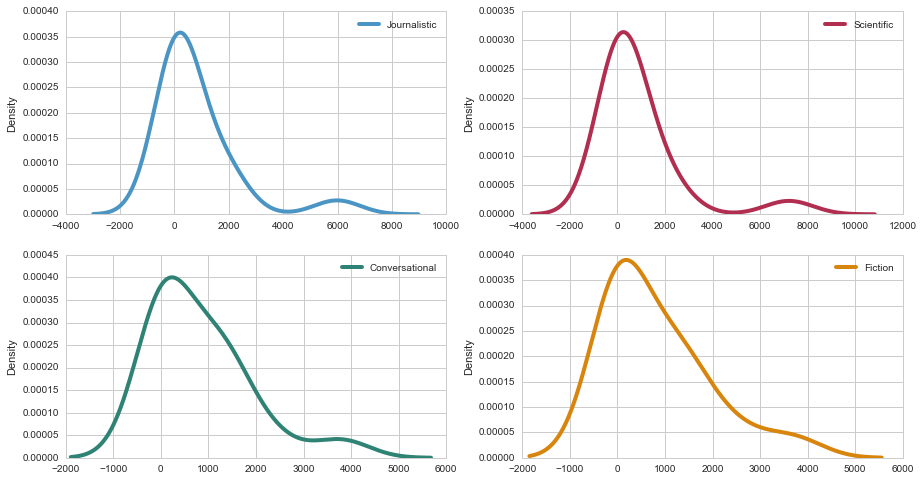

In [320]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

j_df.plot(ax=axes[0,0], kind='kde', color='#4A95C4', linewidth= 4) 
s_df.plot(ax=axes[0,1], kind='kde', color='#B22E50', linewidth= 4)
c_df.plot(ax=axes[1,0], kind='kde', color='#2F8375', linewidth= 4)
f_df.plot(ax=axes[1,1], kind='kde', color='#D8850E', linewidth= 4)

####  График

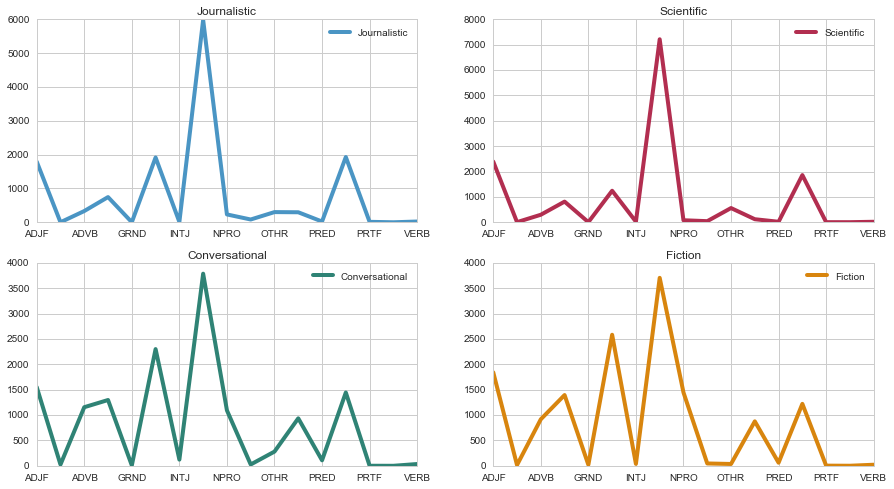

In [321]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8))

j_df.plot(ax=axes[0,0], color='#4A95C4', linewidth= 4); axes[0,0].set_title('Journalistic')

s_df.plot(ax=axes[0,1], color='#B22E50', linewidth= 4); axes[0,1].set_title('Scientific')

c_df.plot(ax=axes[1,0], color='#2F8375', linewidth= 4); axes[1,0].set_title('Conversational')

f_df.plot(ax=axes[1,1], color='#D8850E', linewidth= 4); axes[1,1].set_title('Fiction')

#### еще график
надо оставить либо этот, либо предыдущий, они по смыслу одинаковые 

наверное лучше оставить bar

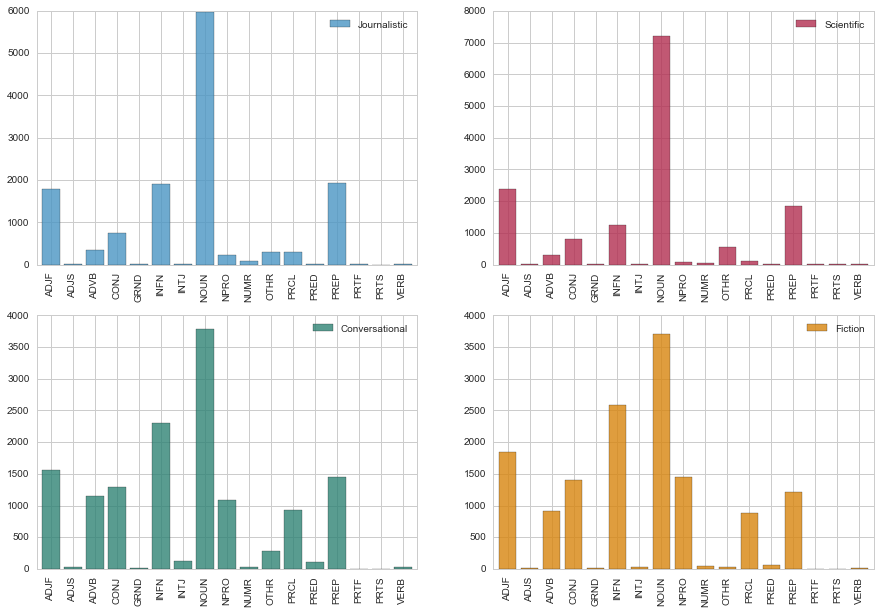

In [322]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

j_df.plot(ax=axes[0,0], kind='bar', color='#4A95C4', width = 0.8, alpha = 0.8) 
s_df.plot(ax=axes[0,1], kind='bar', color='#B22E50', width = 0.8, alpha = 0.8)
c_df.plot(ax=axes[1,0], kind='bar', color='#2F8375', width = 0.8, alpha = 0.8) 
f_df.plot(ax=axes[1,1], kind='bar', color='#D8850E', width = 0.8, alpha = 0.8)